# Dataset Figure        

In [5]:
import sys
sys.path.append("/home/uhrich/Bachelorthesis")

from utils.kinematics.kinematics import forward_kinematics
import numpy as np
from torch import Tensor
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from typing import Iterable
from matplotlib.ticker import NullFormatter
import time
import math
import pandas as pd
from numpy import ndarray
from utils.plot import plot_action_distribution


## Vanilla Sampling

In [6]:


def sample_uniform_angels(n_joints: int, n_samples: int = 1):
    angles = np.random.uniform(0, 2 * np.pi, (n_samples, n_joints))
    return torch.from_numpy(angles)

def collect_end_effector(joint_it: Iterable, n_samples: int) -> Tensor:
    end_effector = []
    for n_joints in joint_it:
        angles = sample_uniform_angels(n_joints=n_joints, n_samples=5000)
        
        end_effector.append(forward_kinematics(angles)[:, -1] / n_joints)
    
    return torch.stack(end_effector)


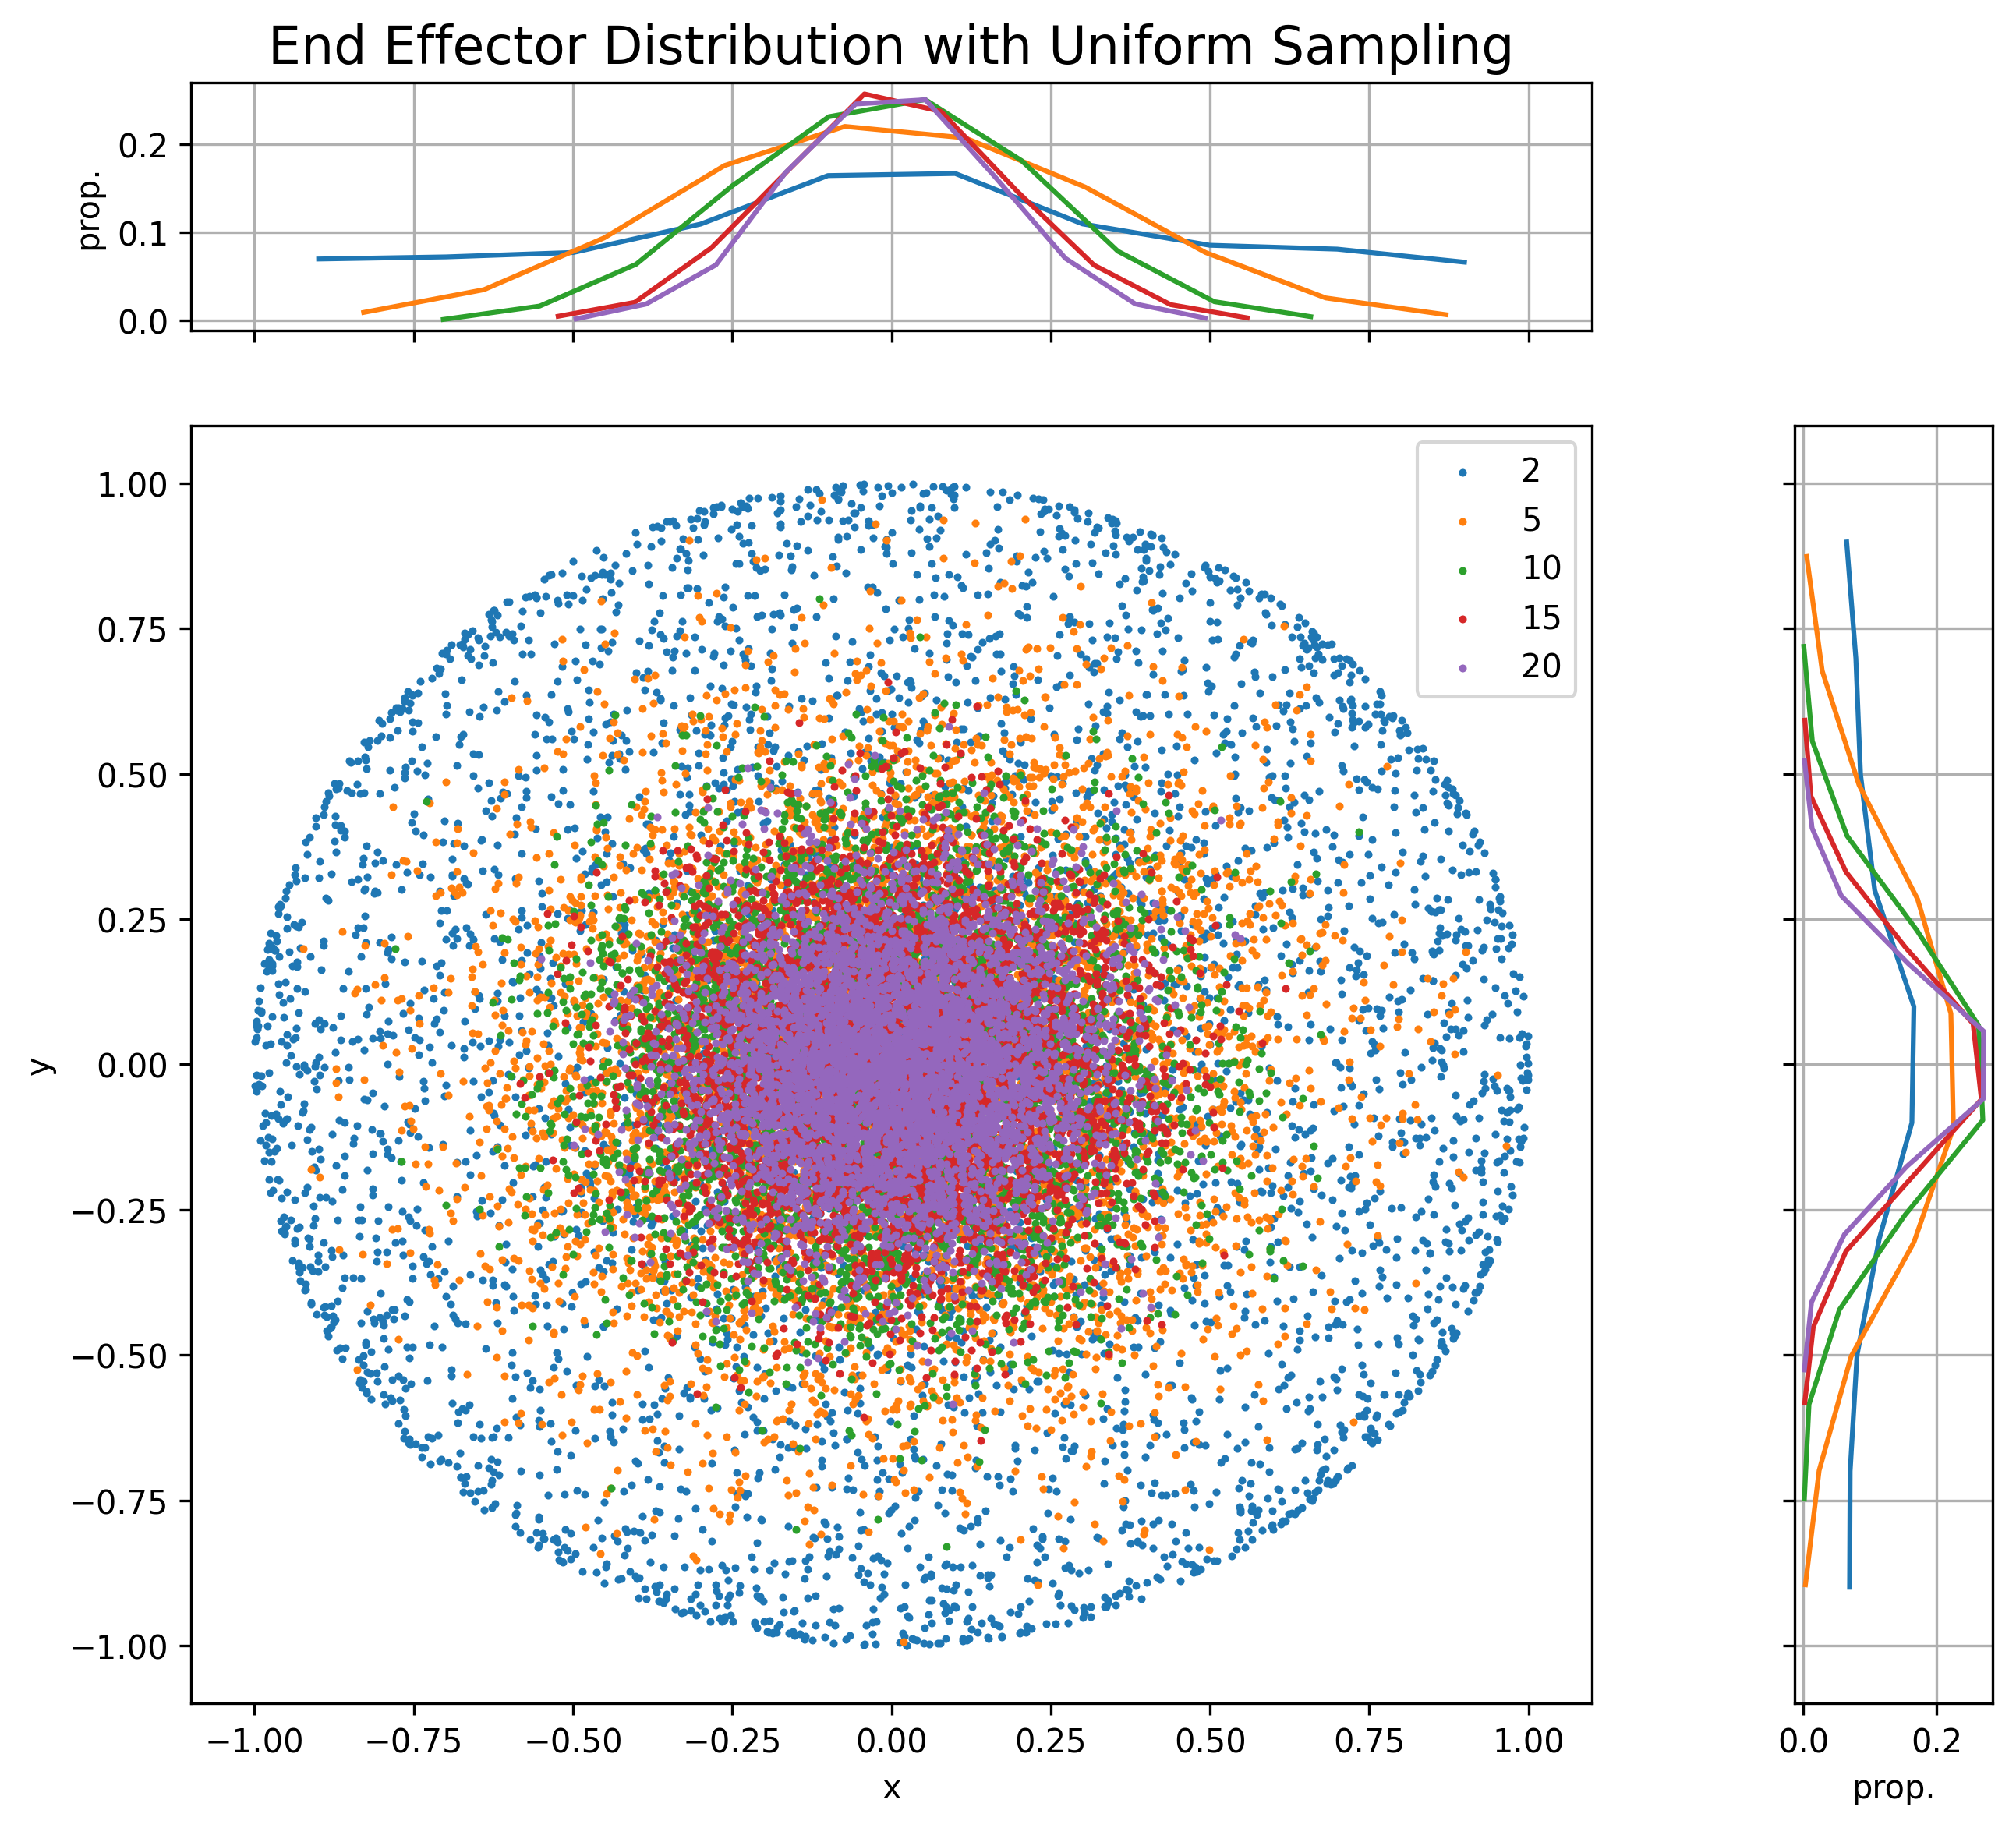

In [7]:
n_samples = 50000

joints = [2, 5, 10, 15, 20]
end_effector = collect_end_effector(joints, n_samples)

fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(10, 12)

# Define the positions of the subplots.
ax0 = plt.subplot(gs[6:10, 5:9])
axx = plt.subplot(gs[5:6, 5:9])
axy = plt.subplot(gs[6:10, 9:10])

#ax0.set_aspect("equal", adjustable="box")
ax0.set_xlabel("x")
ax0.set_ylabel("y")

axx.grid()
axx.set_title("End Effector Distribution with Uniform Sampling", fontsize=16)
axx.set_ylabel("prop.")
axy.set_xlabel("prop.")
axy.grid()

# Remove tick labels
nullfmt = NullFormatter()
axx.xaxis.set_major_formatter(nullfmt)
# axx.yaxis.set_major_formatter(nullfmt)
# axy.xaxis.set_major_formatter(nullfmt)
axy.yaxis.set_major_formatter(nullfmt)

for ele, n_joints in zip(end_effector, joints):
    ax0.scatter(*ele.T, label=n_joints, s=2)
    
    # Top plot
    hx, x_axis = np.histogram(ele[:, 0])
    x_axis = x_axis[:-1] + np.diff(x_axis) / 2
    hx = hx / hx.sum()
    axx.plot(x_axis, hx)
    axx.set_xlim(ax0.get_xlim())
    # Right plot
    hy, x_axis = np.histogram(ele[:, 1])
    x_axis = x_axis[:-1] + np.diff(x_axis) / 2
    hy = hy / hy.sum()
    axy.plot(hy, x_axis)
    axy.set_ylim(ax0.get_ylim())
ax0.legend()
fig.tight_layout()


fig.savefig("../thesis/figures/methodology/relative_end_effector_scatter.png")

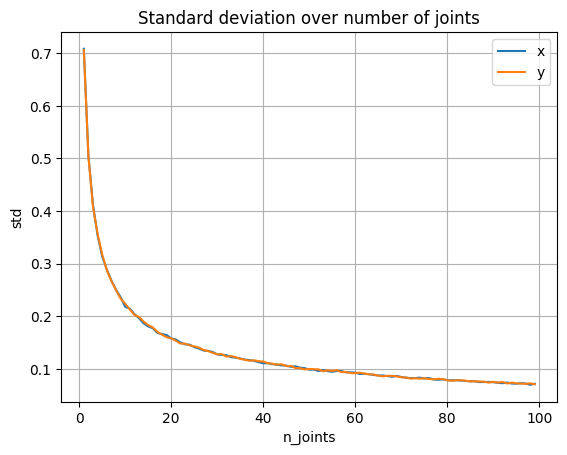

In [6]:
joints = list(range(100))
end_effector = collect_end_effector(joint_it=joints, n_samples=10000)

fig = plt.figure()
ax = fig.add_subplot()

std = end_effector.std(axis=1)
ax.plot(joints, std[:, 0], label="x")
ax.plot(joints, std[:, 1], label="y")
ax.legend()
ax.grid()
ax.set_xlabel("n_joints")
ax.set_ylabel("std")
ax.set_title("Standard deviation over number of joints")
fig.savefig("../thesis/figures/methodology/std_over_n_joints.png")

## Expert Guided sampling

In [7]:

def sample_target(radius: float, n_points: int = 1) -> np.ndarray:
    """
    sample goal position in a circular shape around the origin
    radius and angle is sampled uniformly

    Args:
        radius (float): maximum radius to sample fromm

    Returns:
        np.array: shape (n_points, 2) if  n_point == 1 -> shape: (2)
    """
    # angle to sample from
    theta = np.random.uniform(0, 2 * np.pi, size=n_points)
    radius_array = np.random.uniform(0, radius, size=n_points)
    vector = radius_array * np.array([np.cos(theta), np.sin(theta)])
    return vector.squeeze().T

def rotateZ(theta):
    rz = np.array([[math.cos(theta), - math.sin(theta), 0, 0],
                   [math.sin(theta), math.cos(theta), 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    return rz


def translate(dx, dy, dz):
    t = np.array([[1, 0, 0, dx],
                  [0, 1, 0, dy],
                  [0, 0, 1, dz],
                  [0, 0, 0, 1]])
    return t


# Forward Kinematics
# Input initial angles and length of links
# Output positions each points
def FK(angle, link):
    n_links = len(link)
    P = []
    P.append(np.eye(4))
    for i in range(0, n_links):
        R = rotateZ(angle[i]/180*math.pi)
        T = translate(link[i], 0, 0)
        P.append(P[-1].dot(R).dot(T))
    return P

def ccd(target, angle, link, max_iter = 10000, err_min = 0.1):
    solved = False
    err_end_to_target = math.inf
    
    for loop in range(max_iter):
        for i in range(len(link)-1, -1, -1):
            P = FK(angle, link)
            end_to_target = target - P[-1][:3, 3]
            err_end_to_target = math.sqrt(end_to_target[0] ** 2 + end_to_target[1] ** 2)
            if err_end_to_target < err_min:
                solved = True
            else:
                # Calculate distance between i-joint position to end effector position
                # P[i] is position of current joint
                # P[-1] is position of end effector
                cur_to_end = P[-1][:3, 3] - P[i][:3, 3]
                cur_to_end_mag = math.sqrt(cur_to_end[0] ** 2 + cur_to_end[1] ** 2)
                cur_to_target = target - P[i][:3, 3]
                cur_to_target_mag = math.sqrt(cur_to_target[0] ** 2 + cur_to_target[1] ** 2)

                end_target_mag = cur_to_end_mag * cur_to_target_mag

                if end_target_mag <= 0.0001:    
                    cos_rot_ang = 1
                    sin_rot_ang = 0
                else:
                    cos_rot_ang = (cur_to_end[0] * cur_to_target[0] + cur_to_end[1] * cur_to_target[1]) / end_target_mag
                    sin_rot_ang = (cur_to_end[0] * cur_to_target[1] - cur_to_end[1] * cur_to_target[0]) / end_target_mag

                rot_ang = math.acos(max(-1, min(1,cos_rot_ang)))

                if sin_rot_ang < 0.0:
                    rot_ang = -rot_ang

                # Update current joint angle values
                angle[i] = angle[i] + (rot_ang * 180 / math.pi)

                if angle[i] >= 360:
                    angle[i] = angle[i] - 360
                if angle[i] < 0:
                    angle[i] = 360 + angle[i]
                  
        if solved:
            break
            
    return angle, err_end_to_target, solved, loop

In [7]:
num_samples = 1000
joints  = [2, 5, 10, 15, 20]
times = np.empty((num_samples, len(joints)))
for joint_idx, n_joints in enumerate(joints):
    print(n_joints)
    targets =  np.zeros((num_samples, 3))
    targets[:, :2] = sample_target(radius=n_joints, n_points=num_samples)
    angles = np.zeros(n_joints) 
    segments = np.ones_like(angles)
    for target_idx, target in enumerate(targets):
        start = time.perf_counter()
        ccd(target=target, angle=angles, link=segments)
        times[target_idx, joint_idx] = time.perf_counter() - start

print(times)

2
5


10
15
20
[[9.94658098e-04 1.52543187e-03 5.14525566e-02 6.71403296e-03
  5.41077722e-02]
 [2.63703987e-04 1.37027912e-03 2.90163048e-03 6.30015507e-03
  3.65372375e-03]
 [2.47979537e-04 1.35554187e-03 3.12791206e-03 2.23382726e-01
  6.24574762e-01]
 ...
 [1.67174265e-04 2.49634422e-02 1.06711686e-03 1.66287478e-02
  1.25829894e-01]
 [1.67325139e-04 5.34655526e-04 1.80179678e-01 2.22987123e-01
  3.96255761e-01]
 [1.07271597e-04 1.43711455e-03 1.09073650e-02 6.18622638e-03
  1.43324211e-02]]


In [8]:
from numpy import ndarray


def exponential_density(lmbda: float, x: ndarray):
    return lmbda * np.exp(-lmbda * x)

def pareto_cdf(b: float, x: ndarray):
    return b / np.float_power(x, b + 1)


NameError: name 'times' is not defined

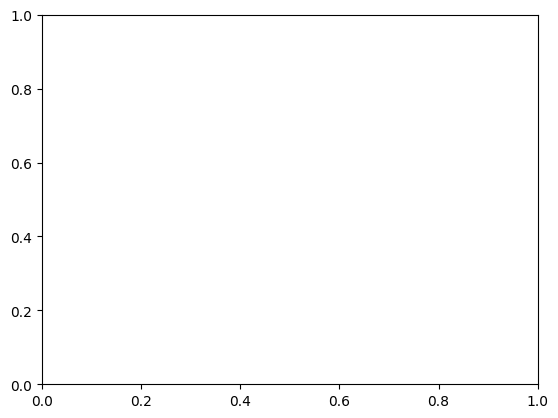

In [9]:
from distfit import distfit
from scipy.stats._continuous_distns import pareto_gen

fig = plt.figure()
ax = fig.add_subplot()

for joint_times, n_joints in zip(times.T, joints):
    hx, x_axis = np.histogram(joint_times)
    x_axis = x_axis[:-1] + np.diff(x_axis) / 2
    ax.plot(x_axis, hx / hx.sum(), label=n_joints)

    # plot exponential distributions
    x_axis = np.linspace(min(x_axis), max(x_axis), 100)
    df = distfit(verbose="critical")
    result = df.fit_transform(joint_times)
    df_fig, _ = df.plot()
    df_fig.savefig(f"../thesis/figures/methodology/dataset/best_ccd_run_time_fit_{n_joints}.png")
    # y = exponential_density(lmbda=lmbda, x=x_axis)
    # y = pareto.pdf(x_axis, 3.8153)
    # y = df.predict(x_axis)["y_proba"]
    # y = np.exp(-x_axis * 3500 + 3.8)
    # y_5 = np.exp(-x_axis * 3+ 4.3)
    # y_10 = np.exp(-x_axis * 3+ 4.3)
    # y_15 = np.exp(-x_axis * 3+ 4.3)
    # y_20 = np.exp(-x_axis * 3+ 4.3)
    # ax.plot(x_axis, y, "--k")
ax.set_title("Histogram of runtime vs number of joints")
ax.set_xscale("log")
ax.set_xlabel("runtime in seconds")
ax.set_ylabel("probability")
ax.grid()
ax.legend()

fig.savefig("../thesis/figures/methodology/dataset/runtime_histograms.png")



NameError: name 'times' is not defined

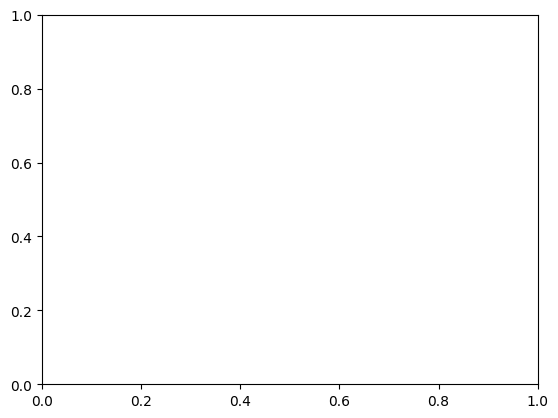

In [7]:
fig = plt.figure()
ax = fig.add_subplot()

means = times.mean(axis=0)
joints = [2, 5, 10, 15, 20]
print(means.shape)
print(joints)
diff = np.zeros_like(means)
diff[1:] = np.diff(means)
ax.plot(joints, means, label="mean runtime")
ax.plot(joints, diff, "--k", label="first order derivation")

ax.set_xlabel("n joints")
ax.set_ylabel("runtime in seconds")
ax.set_title("Emprical Runtime Complexity of CCD")
ax.grid()
ax.legend()

fig.savefig("../thesis/figures/methodology/dataset/runtime_complexity")

## Joint Action Correlation

In [20]:
def get_actions(n_joints: int, n_samples: int):
    targets = np.zeros((n_samples, 3))
    targets[:, :2] = sample_target(radius=n_joints, n_points=n_samples)
    angles = sample_uniform_angels(n_joints=n_joints, n_samples=n_samples)
    segments = np.ones_like(angles[0])
    actions = np.empty((n_samples, n_joints))
    for sample_idx, (target, angle) in enumerate(zip(targets, angles)):
        action, _, _, _ = ccd(target=target, angle=angle.clone(), link=segments)
        action = action.cumsum(0)
        action = np.deg2rad(action)
        actions[sample_idx] = action
    return actions

In [9]:
actions = get_actions(10, 1000)

KeyboardInterrupt: 

In [11]:
plt.imshow(np.cov(actions.T))

NameError: name 'actions' is not defined

In [21]:
actions = get_actions(2, 10000)

In [12]:
def is_in(lower: float, upper: float, x: ndarray):
    assert lower <= upper
    return (x <= upper) & (x>=lower)

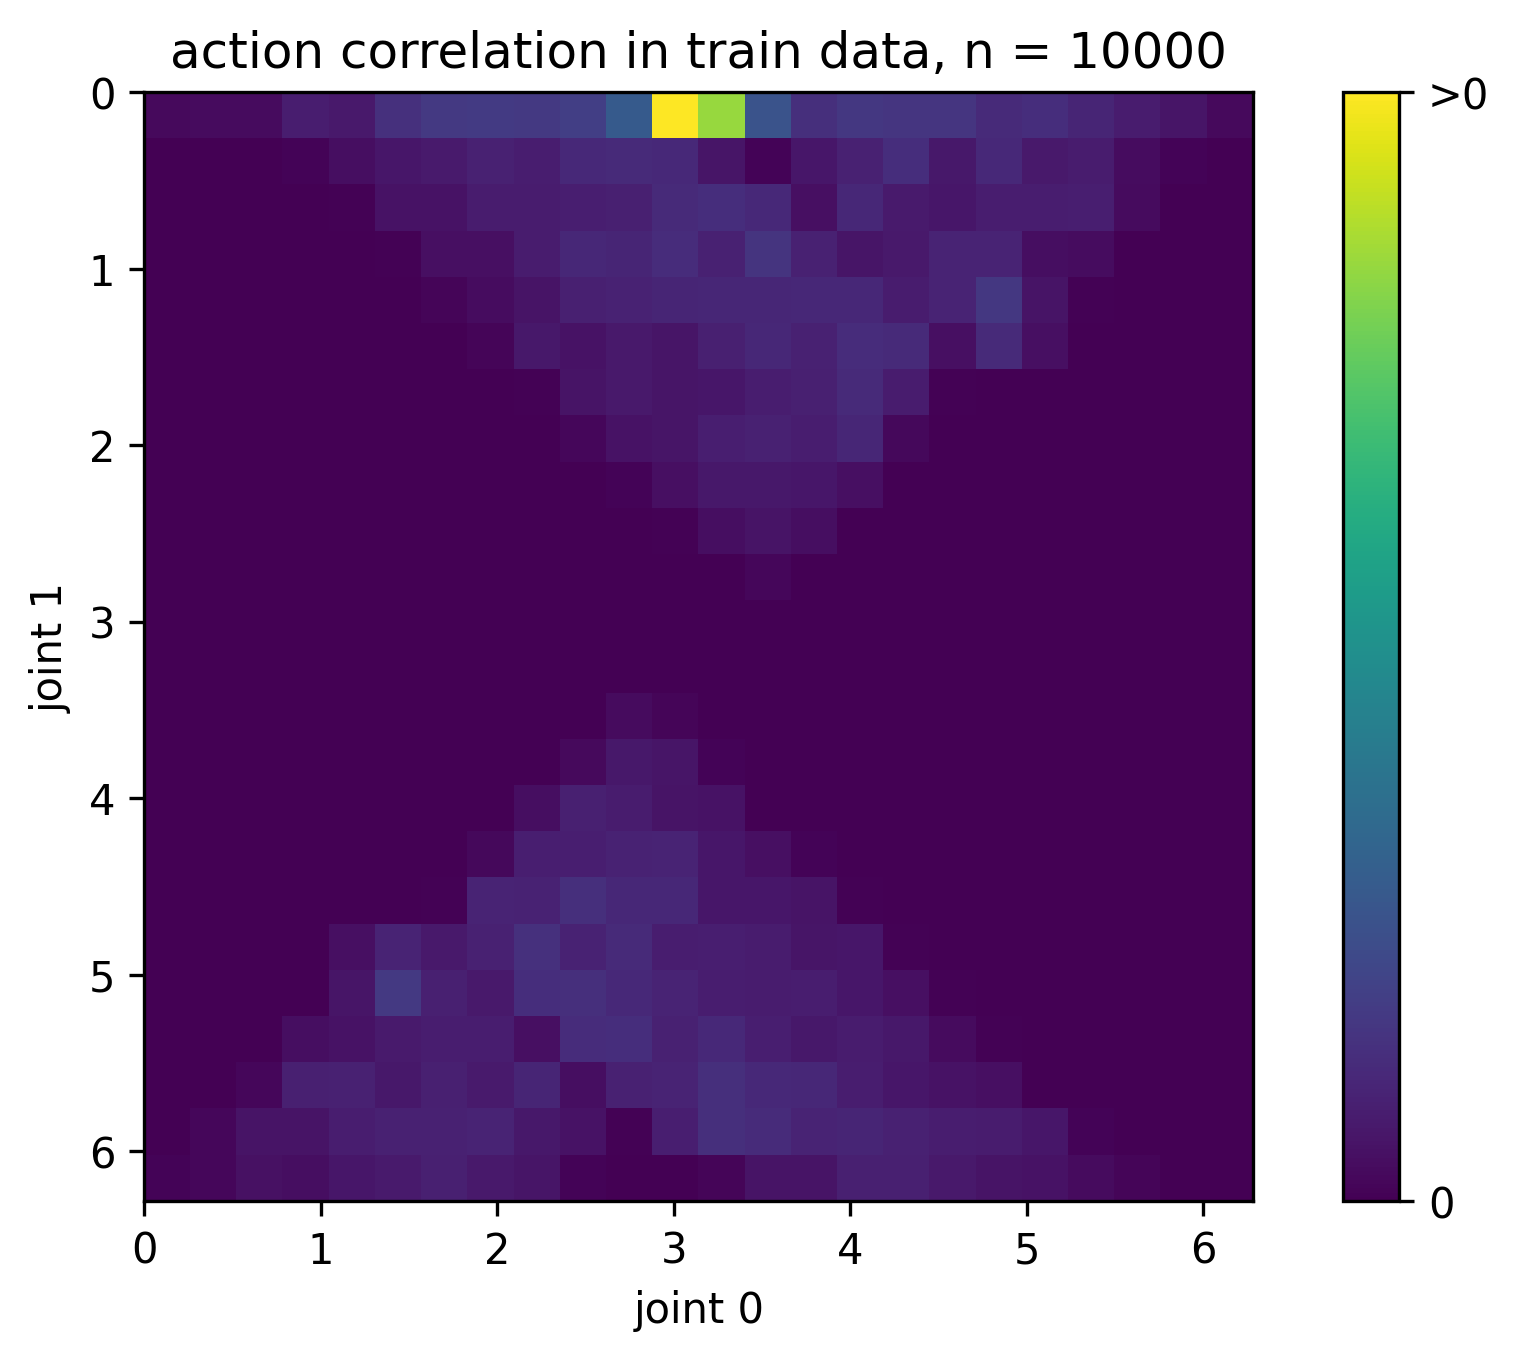

In [3]:
bins = np.linspace(0, 2*np.pi, 25)

joint_angles = pd.read_csv("../../data/2/train/states_IK_random_start.csv").to_numpy()[:, 4:]
h, _, _= np.histogram2d(joint_angles[:, 0], joint_angles[:, 1], bins=bins)

fig, _ = plot_action_distribution(actions=joint_angles, colorbar=True, title="action correlation in train data")
fig.savefig("../thesis/figures/methodology/dataset/action_correlation.png")